<a href="https://colab.research.google.com/github/pablex72/research-camp-time-ser/blob/main/LSTM_update_12a_3lay_32_16_32_do0_3_rs0_79_0_83_e1500_new_data_222_w_scatter_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [176]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**Loading the data**

In [177]:
df = pd.read_csv('/content/interpolated_data_farm1.csv')
df

,Date,NDVI
0,2019-10-08,0.217740
1,2019-10-13,0.162023
2,2019-10-18,0.120414
3,2019-10-23,0.091932
4,2019-10-28,0.075591
...,...,...
259,2023-04-25,0.261654
260,2023-04-30,0.217323
261,2023-05-05,0.171169
262,2023-05-10,0.123351


# Plotting full Dataset

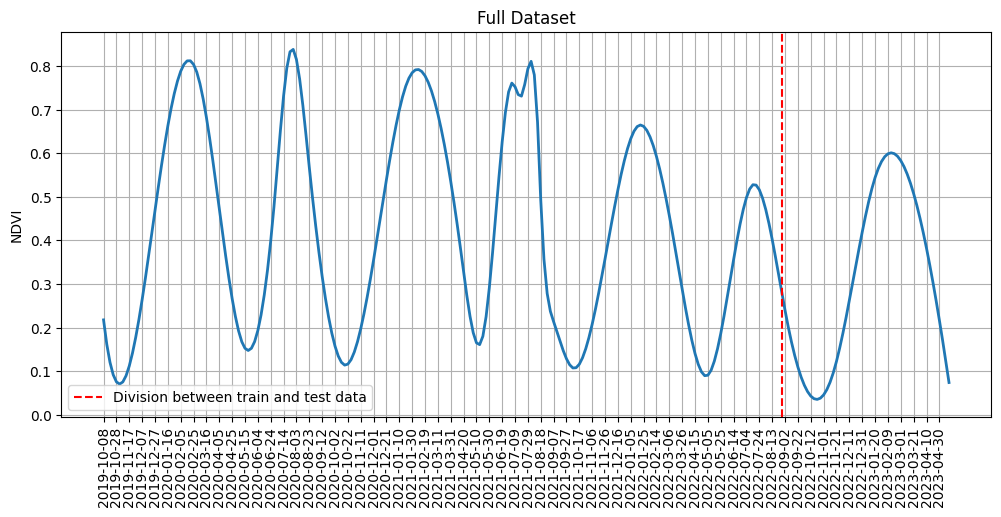

In [178]:
#Plotting the Full Dataset
fig, ax = plt.subplots(figsize=(12, 5))
index_80_percent = int(len(df) * 0.8)

ax.plot(df['NDVI'], linewidth=2)
ax.set_xticks(range(0, len(df['Date'].values), 4))
ax.set_xticklabels(df['Date'].values[::4], rotation=90)
ax.set_ylabel('NDVI') # set the label for the y-axis
ax.set_title('Full Dataset')
ax.axvline(df.index[index_80_percent], 0, 1, label='Division between train and test data', c='r', linestyle='--')
ax.legend()
ax.grid(True)
plt.show()

**Preprocessing the data**

In [179]:
dfDate = df[['Date']]  #index, date (dataframe)

In [180]:
#making date column into index column
df.index = df.pop('Date') #date, ndvi (no index) (dataframe)

In [181]:
testDf = df
df = df.values # ndvi (array)

In [182]:
dfDate=dfDate.values
#dfDate = np.array(dfDate)
dfDate = dfDate.flatten() # date ()

# Feature length

In [183]:
feature_length = 3

# Splitting



Creating Feature and Target with X and y respectively

In [184]:
def Create_Features_and_Targets(data, dates, feature_length):
  X = list()
  Y = list()
  datesF = list()
  for i in range(len(data) - feature_length - 1):
    X.append(data[i:(i + feature_length), :])
    Y.append(data[i + feature_length, -1])
  X = np.array(X)
  Y = np.array(Y)
  datesF = np.array(dates[feature_length+1:])
  return datesF, X, Y

In [185]:
dates, X, y = Create_Features_and_Targets(df,dfDate, feature_length)
dates.shape, X.shape, y.shape

((260,), (260, 3, 1), (260,))

In [186]:
q_80 = int(len(dates) * .8)
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

In [187]:
dates_test, X_test, y_test = dates[q_80:], X[q_80:], y[q_80:]

# LSTM Model

MODEL CREATION

In [188]:
# Create the model by importing the required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

Adam will be used as an optimizer for the LSTM model

In [189]:
from keras.optimizers import Adam

# Define the optimizer with a lower learning rate
adam = Adam(lr=0.001)

MODEL SECUENTIAL: 2 LSTM layers, 2 dropout layers, and 1 dense layer.

In [190]:
# LSTMs are recurrent neural networks (RNNs). In simple terms, LSTMs work by allowing the network to remember
# the context of the model while forgetting the irrelevant information.
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(16, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(1, activation='sigmoid'),
])
model.compile(optimizer=adam, loss="mean_squared_error")
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 3, 32)             4352      
                                                                 
 dropout_18 (Dropout)        (None, 3, 32)             0         
                                                                 
 lstm_28 (LSTM)              (None, 3, 16)             3136      
                                                                 
 dropout_19 (Dropout)        (None, 3, 16)             0         
                                                                 
 lstm_29 (LSTM)              (None, 32)                6272      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13793 (53.88 KB)
Trainable params: 13793

MODEL FIT: With this the model can be trained.

In [191]:
history = model.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 12,
    verbose = 0,
)

# Predicting

In [192]:
y_pred = model.predict(X_test)

2/2 [==============================] - 1s 7ms/step


# RMSE, MSE, MAE, R2

In [193]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calculate predicted values
y_pred_lstm = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred_lstm)
rmse = mean_squared_error(y_test, y_pred_lstm, squared=False)
mse = mean_squared_error(y_test, y_pred_lstm, squared=True)
mae = mean_absolute_error(y_test, y_pred_lstm)

# Print the evaluation metrics
print("LSTM R^2 score: ", r2)
print("LSTM Root Mean Squared Error (RMSE): ", rmse)
print("LSTM Mean Squared Error (MSE): ", mse)
print("LSTM Mean Absolute Error (MAE): ", mae)



2/2 [==============================] - 0s 5ms/step
LSTM R^2 score:  0.9891517411527126
LSTM Root Mean Squared Error (RMSE):  0.020610758114514738
LSTM Mean Squared Error (MSE):  0.00042480335005503505
LSTM Mean Absolute Error (MAE):  0.01638167414588966


# Plotting prediction TEST

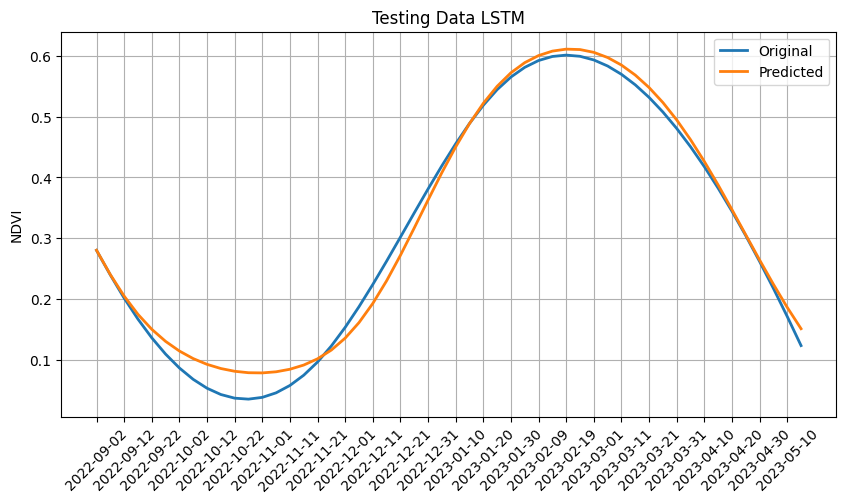

In [194]:
#Plot Testing Data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_test, linewidth=2, label = 'Original')
ax.plot(y_pred_lstm, linewidth=2, label = 'Predicted')
ax.set_xticks(range(0, len(dates_test), 2))
ax.set_xticklabels(dates_test[::2], rotation=45)

ax.set_title('Testing Data LSTM')
ax.set_ylabel('NDVI')
ax.legend()
ax.grid(True)
plt.show()

#svm

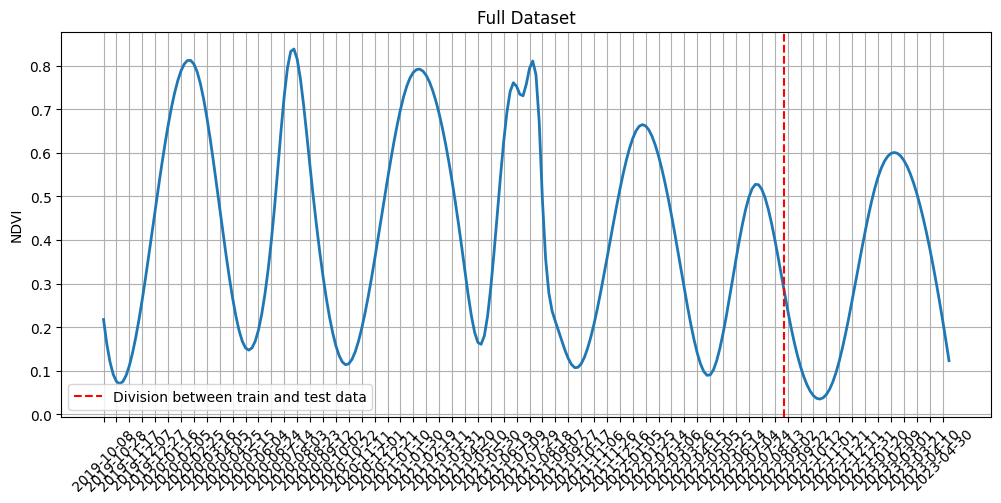

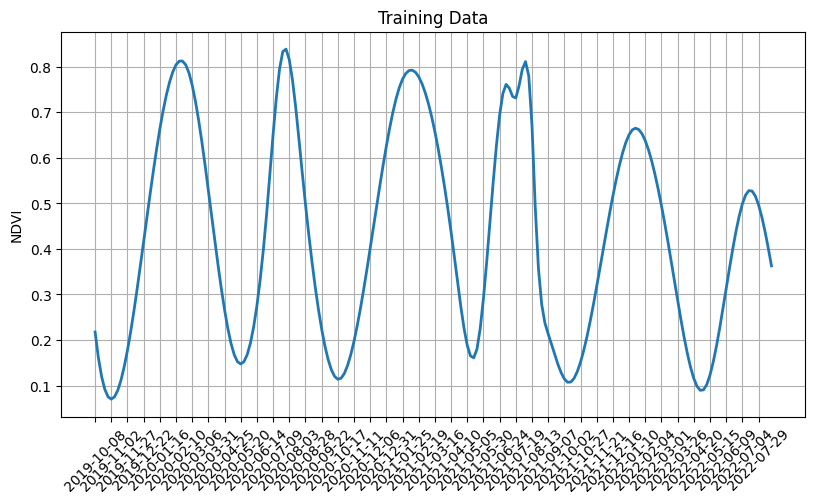

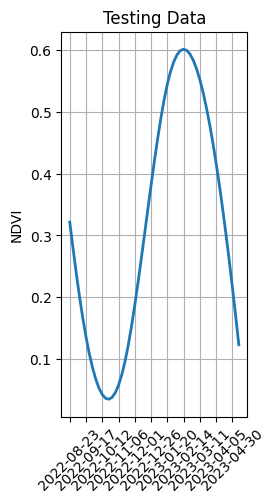

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear Kernel:
R^2 score: 0.9114531325960923
RMSE: 0.05911275798037839
MSE: 0.003494318156046789
MAE: 0.04969255227702359

Spline R^2 score:  0.9114531325960923
Spline Root Mean Squared Error (RMSE):  0.05911275798037839
Spline Mean Squared Error (MSE):  0.003494318156046789
Spline Mean Absolute Error (MAE):  0.04969255227702359


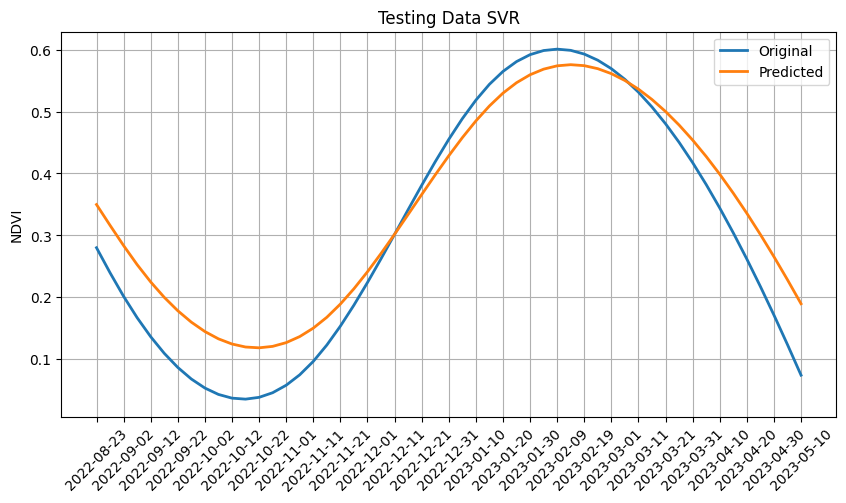

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/interpolated_data_farm1.csv")
df

# Build the target, the next NDVI value
df['Target'] = df['NDVI'].shift(-1) # Target NDVI will be the next Sample
target_df = df[:-1]
target_df

#Plotting the Full Dataset
fig, ax = plt.subplots(figsize=(12, 5))
index_80_percent = int(len(df) * 0.8)

ax.plot(target_df['NDVI'], linewidth=2)
ax.set_xticks(range(0, len(df['Date'].values), 4))
ax.set_xticklabels(df['Date'].values[::4], rotation=45)
ax.set_ylabel('NDVI') # set the label for the y-axis
ax.set_title('Full Dataset')
ax.axvline(df.index[index_80_percent], 0, 1, label='Division between train and test data', c='r', linestyle='--')
ax.legend()
ax.grid(True)
plt.show()

# Creating Feature and Target with X and y respectively
X = target_df[['NDVI', 'Target']].values[:,:1]
y = target_df[['NDVI', 'Target']].values[:,1:]

X.shape, y.shape
#((124, 1), (124, 1))


# Spliting the data into train(80%) and test(20%) parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)
# Splitting the dates
train_dates = target_df.Date[:int(len(X)*0.80)]
test_dates =  target_df.Date[int(len(X)*0.80):]


X_train.shape, X_test.shape, y_train.shape, y_test.shape
#((99, 1), (25, 1), (99, 1), (25, 1))

#Plot Training Data
fig, ax = plt.subplots(figsize=(9.6, 5))
ax.plot(X_train, linewidth=2)

ax.set_xticks(range(0, len(train_dates.values), 5))
ax.set_xticklabels(train_dates.values[::5], rotation=45)

ax.set_title('Training Data')
ax.set_ylabel('NDVI')

ax.grid(True)
plt.show()

#Plot Testing Data
fig, ax = plt.subplots(figsize=(2.4, 5))
ax.plot(X_test, linewidth=2)

ax.set_xticks(range(0, len(test_dates.values), 5))
ax.set_xticklabels(test_dates.values[::5], rotation=45)

ax.set_title('Testing Data')
ax.set_ylabel('NDVI') # set the label for the y-axis
ax.grid(True)
plt.show()

from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Linear Kernel
regressor_linear = SVR(kernel='linear')
regressor_linear.fit(X_train, y_train)
y_pred_linear = regressor_linear.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
mse_linear = mean_squared_error(y_test, y_pred_linear, squared=True)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
print("Linear Kernel:")
print("R^2 score:", r2_linear)
print("RMSE:", rmse_linear)
print("MSE:", mse_linear)
print("MAE:", mae_linear)
print()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Create an SVM regressor
regressor = SVR(kernel='linear')

# Train the regressor
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = regressor.predict(X_test)


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred_svm)
rmse = mean_squared_error(y_test, y_pred_svm, squared=False)
mse = mean_squared_error(y_test, y_pred_svm, squared=True)
mae = mean_absolute_error(y_test, y_pred_svm)

# Print the evaluation metrics
print("Spline R^2 score: ", r2)
print("Spline Root Mean Squared Error (RMSE): ", rmse)
print("Spline Mean Squared Error (MSE): ", mse)
print("Spline Mean Absolute Error (MAE): ", mae)

# SMV  Spline R^2 score:  0.6535873850603777

#spline 0.76


#Plot Testing Data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_test, linewidth=2, label = 'Original')
ax.plot(y_pred_svm, linewidth=2, label = 'Predicted')
ax.set_xticks(range(0, len(test_dates.values), 2))
ax.set_xticklabels(test_dates.values[::2], rotation=45)

ax.set_title('Testing Data SVR')
ax.set_ylabel('NDVI')
ax.legend()
ax.grid(True)
plt.show()

In [202]:
y_pred_svm.shape

(53,)

In [201]:
y_pred_svm

array([0.34979974, 0.31621623, 0.28346795, 0.25265391, 0.22470102,
       0.1998479 , 0.17816109, 0.15970713, 0.14455257, 0.13276394,
       0.12440778, 0.11955064, 0.11825905, 0.12059955, 0.12663869,
       0.13644299, 0.15007902, 0.16761329, 0.18899827, 0.21373003,
       0.24119055, 0.27076183, 0.30182585, 0.33376459, 0.36596004,
       0.39779419, 0.42864902, 0.45790652, 0.48494868, 0.50915747,
       0.5299149 , 0.54672756, 0.55960053, 0.56866354, 0.57404627,
       0.57587845, 0.57428977, 0.56940995, 0.56136868, 0.55029568,
       0.53632065, 0.51957329, 0.50018332, 0.47828044, 0.45399436,
       0.42745478, 0.39879141, 0.36813396, 0.33561213, 0.30135563,
       0.26549416, 0.22815744, 0.18947517])

#random forest

Random Forest R^2 score:  0.9521043317478524
Random Forest Root Mean Squared Error (RMSE):  0.04347531528290786
Random Forest Mean Squared Error (MSE):  0.0018901030389482417
Random Forest Mean Absolute Error (MAE):  0.035439237009171023


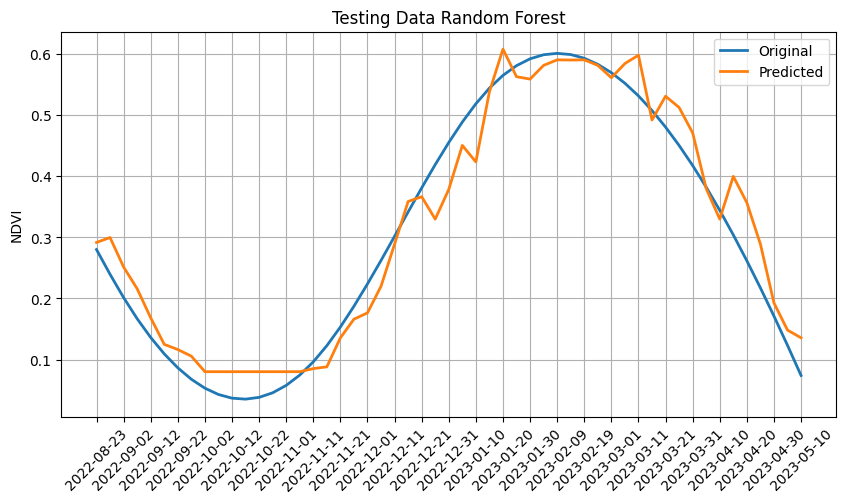

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Load your data
df = pd.read_csv("/content/interpolated_data_farm1.csv")

# Build the target, the next NDVI value
df['Target'] = df['NDVI'].shift(-1)
target_df = df[:-1]

# Creating Feature and Target
X = target_df[['NDVI']].values
y = target_df['Target'].values

# Split the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

# Define test_dates
test_dates = target_df['Date'][int(len(X) * 0.80):]

# Create a Random Forest regressor
regressor_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the regressor
regressor_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = regressor_rf.predict(X_test)

# Calculate evaluation metrics
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mse_rf = mean_squared_error(y_test, y_pred_rf, squared=True)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Print the evaluation metrics
print("Random Forest R^2 score: ", r2_rf)
print("Random Forest Root Mean Squared Error (RMSE): ", rmse_rf)
print("Random Forest Mean Squared Error (MSE): ", mse_rf)
print("Random Forest Mean Absolute Error (MAE): ", mae_rf)

# Plot Testing Data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_test, linewidth=2, label='Original')
ax.plot(y_pred_rf, linewidth=2, label='Predicted')
ax.set_xticks(range(0, len(test_dates.values), 2))
ax.set_xticklabels(test_dates.values[::2], rotation=45)
ax.set_title('Testing Data Random Forest')
ax.set_ylabel('NDVI')
ax.legend()
ax.grid(True)
plt.show()


In [199]:
y_pred_rf.shape

(53,)

In [198]:
y_pred_rf

array([0.29166295, 0.29971533, 0.25142469, 0.21594621, 0.16837581,
       0.12494273, 0.11646116, 0.10561216, 0.08022386, 0.08022386,
       0.08022386, 0.08022386, 0.08022386, 0.08022386, 0.08022386,
       0.08022386, 0.08524806, 0.08815021, 0.13563088, 0.16612942,
       0.17643534, 0.22002114, 0.28893663, 0.35865507, 0.36652252,
       0.32982721, 0.37851118, 0.45043245, 0.42338767, 0.53827249,
       0.60791003, 0.56281694, 0.55889528, 0.58136127, 0.59039089,
       0.59008704, 0.59039089, 0.58136127, 0.56108916, 0.58433022,
       0.59806079, 0.49198366, 0.53086181, 0.51250033, 0.4709347 ,
       0.37978337, 0.32982721, 0.39979961, 0.35667819, 0.28893663,
       0.19271577, 0.14828332, 0.13563088])

#Adding other s for one farm

In [205]:
y_pred_rf, y_pred_svm, y_pred_rf.shape, y_pred_svm.shape

(array([0.29166295, 0.29971533, 0.25142469, 0.21594621, 0.16837581,
        0.12494273, 0.11646116, 0.10561216, 0.08022386, 0.08022386,
        0.08022386, 0.08022386, 0.08022386, 0.08022386, 0.08022386,
        0.08022386, 0.08524806, 0.08815021, 0.13563088, 0.16612942,
        0.17643534, 0.22002114, 0.28893663, 0.35865507, 0.36652252,
        0.32982721, 0.37851118, 0.45043245, 0.42338767, 0.53827249,
        0.60791003, 0.56281694, 0.55889528, 0.58136127, 0.59039089,
        0.59008704, 0.59039089, 0.58136127, 0.56108916, 0.58433022,
        0.59806079, 0.49198366, 0.53086181, 0.51250033, 0.4709347 ,
        0.37978337, 0.32982721, 0.39979961, 0.35667819, 0.28893663,
        0.19271577, 0.14828332, 0.13563088]),
 array([0.34979974, 0.31621623, 0.28346795, 0.25265391, 0.22470102,
        0.1998479 , 0.17816109, 0.15970713, 0.14455257, 0.13276394,
        0.12440778, 0.11955064, 0.11825905, 0.12059955, 0.12663869,
        0.13644299, 0.15007902, 0.16761329, 0.18899827, 0.21373003,
  

In [203]:

# Calculate the Pearson correlation coefficient (cross-correlation) between the actual values and predicted values for each model
correlation_rf = np.corrcoef(y_test, y_pred_rf)[0, 1]
correlation_gb = np.corrcoef(y_test, y_pred_svm)[0, 1]
correlation_xgb = np.corrcoef(y_test, y_pred_lstm)[0, 1]

# Print the Pearson correlation coefficients
print("Random Forest Pearson Correlation Coefficient:", correlation_rf)
print("GradientBoostingRegressor Pearson Correlation Coefficient:", correlation_gb)
print("XGBoost Pearson Correlation Coefficient:", correlation_xgb)

# Create a scatter plot to visualize the correlation between actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, label=f"Random Forest (r={correlation_rf:.4f})", alpha=0.8)
plt.scatter(y_test, y_pred_gb, label=f"GradientBoosting (r={correlation_gb:.4f})", alpha=0.8)
plt.scatter(y_test, y_pred_xgb, label=f"XGBoost (r={correlation_xgb:.4f})", alpha=0.8)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title("Scatter Plot of Actual vs. Predicted NDVI")
plt.legend()
plt.grid(True)
plt.show()

ValueError: ignored